In [43]:
import numpy.polynomial.polynomial as poly
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


from datetime import datetime
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.utils import column_or_1d

from keras.models import Sequential 
from keras.layers import Dense, GRU
from keras.layers import Conv1D, Conv2D, MaxPooling2D, Flatten, Dense, RepeatVector 

In [44]:
# Đọc dữ liệu từ tệp CSV
data = pd.read_csv('vcb.csv')

In [45]:
# Xử lý dữ liệu
prices = data['Price']

In [46]:
# Chuẩn hóa dữ liệu
scaler = MinMaxScaler()
scaled_prices = scaler.fit_transform(prices.values.reshape(-1, 1))

In [47]:
scaled_prices

array([[0.08754242],
       [0.08647225],
       [0.091809  ],
       ...,
       [0.67895011],
       [0.68880691],
       [0.65782841]])

In [48]:
#RATIO 73

In [49]:
# Chia dữ liệu thành tập train test


train_size = int(len(scaled_prices) * 0.8)
test_size = int(len(scaled_prices) * 0.2)

train_data = scaled_prices[:train_size]
test_data = scaled_prices[train_size:train_size+test_size]

In [50]:
test_data

array([[0.37338947],
       [0.40155174],
       [0.43675458],
       [0.4592844 ],
       [0.43393835],
       [0.45365194],
       [0.45646817],
       [0.47477365],
       [0.45787628],
       [0.45787628],
       [0.48463044],
       [0.48603855],
       [0.50997648],
       [0.50856837],
       [0.53532253],
       [0.55644423],
       [0.53673064],
       [0.52828196],
       [0.5113846 ],
       [0.5113846 ],
       [0.52264951],
       [0.5423631 ],
       [0.52546573],
       [0.5634848 ],
       [0.55785235],
       [0.55644423],
       [0.55785235],
       [0.57756593],
       [0.57756593],
       [0.55644423],
       [0.53532253],
       [0.53532253],
       [0.52828196],
       [0.52969007],
       [0.58038216],
       [0.62403368],
       [0.64093104],
       [0.62684991],
       [0.69725559],
       [0.69725559],
       [0.62684991],
       [0.60572821],
       [0.5846065 ],
       [0.58883084],
       [0.59023896],
       [0.60150387],
       [0.60995255],
       [0.619

In [51]:
# Chia dữ liệu thành các mẫu chuỗi thời gian
def create_time_series(data, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i+time_steps])
        y.append(data[i+time_steps])
    return np.array(X), np.array(y)


In [52]:
time_steps = 30  # Số ngày quan sát trước để dự đoán ngày tiếp theo
X_train, y_train = create_time_series(train_data, time_steps)
X_test, y_test = create_time_series(test_data, time_steps)

In [53]:
X_train.shape

(1160, 30, 1)

In [54]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [55]:
# 8. Define GRU Model

model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(time_steps, 1)))
model.add(Conv1D(filters=64, kernel_size=3, activation='softmax'))
model.add(GRU(64, return_sequences = False))
model.add(Dense(50, activation='relu'))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

In [56]:
# Biên dịch mô hình
model.compile(optimizer='adam', loss='mean_squared_error')

# Huấn luyện mô hình
model.fit(X_train, y_train, epochs=100, batch_size=64)

# Đánh giá mô hình trên tập kiểm tra
loss = model.evaluate(X_test, y_test)
print('Loss trên tập kiểm tra:', loss)

Epoch 1/100
19/19 [==============================] - 2s 7ms/step - loss: 0.1093
Epoch 2/100
19/19 [==============================] - 0s 7ms/step - loss: 0.0396
Epoch 3/100
19/19 [==============================] - 0s 7ms/step - loss: 0.0354
Epoch 4/100
19/19 [==============================] - 0s 7ms/step - loss: 0.0302
Epoch 5/100
19/19 [==============================] - 0s 7ms/step - loss: 0.0214
Epoch 6/100
19/19 [==============================] - 0s 7ms/step - loss: 0.0061
Epoch 7/100
19/19 [==============================] - 0s 7ms/step - loss: 0.0015
Epoch 8/100
19/19 [==============================] - 0s 7ms/step - loss: 0.0011
Epoch 9/100
19/19 [==============================] - 0s 7ms/step - loss: 0.0011
Epoch 10/100
19/19 [==============================] - 0s 7ms/step - loss: 0.0011
Epoch 11/100
19/19 [==============================] - 0s 7ms/step - loss: 0.0010
Epoch 12/100
19/19 [==============================] - 0s 7ms/step - loss: 0.0012
Epoch 13/100
19/19 [=================

In [57]:
data.index


RangeIndex(start=0, stop=1488, step=1)

In [58]:
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay

# Tạo biến train, test
train = prices[:train_size]
test = prices[train_size:train_size+test_size]

y_test_pred = model.predict(X_test)
y_test_pred = scaler.inverse_transform(y_test_pred)

n_past = 1
n_days_for_prediction= 30

#create an array of 30 integers starting from last index
predict_period_dates = np.array(range(len(data) + 1,len(data) + 31)).reshape(-1, 1)

print(predict_period_dates)

#Make prediction
prediction1 = model.predict(X_test[-n_days_for_prediction:])

prediction_copies1 = np.repeat(prediction1, prices.shape[0], axis=-1)
predicted_prices = scaler.inverse_transform(prediction_copies1)[:,0]
print(predicted_prices)

9/9 [==============================] - 0s 2ms/step
[[1489]
 [1490]
 [1491]
 [1492]
 [1493]
 [1494]
 [1495]
 [1496]
 [1497]
 [1498]
 [1499]
 [1500]
 [1501]
 [1502]
 [1503]
 [1504]
 [1505]
 [1506]
 [1507]
 [1508]
 [1509]
 [1510]
 [1511]
 [1512]
 [1513]
 [1514]
 [1515]
 [1516]
 [1517]
 [1518]]
1/1 [==============================] - 0s 16ms/step
[87055.84  87469.945 87759.13  87318.35  87493.516 87007.17  85607.99
 84466.234 84405.49  85486.586 86374.375 85441.195 84749.516 84953.44
 85312.21  84791.516 84592.23  84571.66  84579.88  84201.336 83741.82
 83681.62  84303.1   84438.08  84551.98  84300.64  83984.04  83413.99
 83108.59  82792.375]


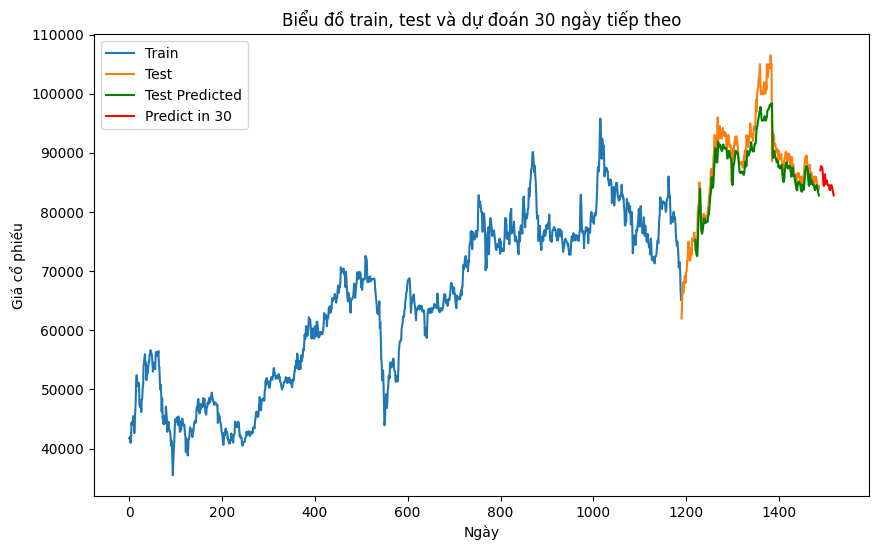

In [59]:
# Tạo biểu đồ train, test và dự đoán 30 ngày tiếp theo
plt.figure(figsize=(10, 6))
plt.plot(train, label='Train')
plt.plot(range(train_size, train_size + len(test)), test, label='Test')

plt.plot(range(train_size + 30,train_size + test_size), y_test_pred, 'g', label='Test Predicted')

plt.plot(predict_period_dates, predicted_prices, 'r', label='Predict in 30')

plt.xlabel('Ngày')
plt.ylabel('Giá cổ phiếu')
plt.title('Biểu đồ train, test và dự đoán 30 ngày tiếp theo')
plt.legend()
plt.show()

In [60]:
y_test_pred

array([[75290.67 ],
       [73768.1  ],
       [72961.29 ],
       [72603.836],
       [72534.81 ],
       [74512.97 ],
       [77782.45 ],
       [80072.445],
       [80091.61 ],
       [82198.13 ],
       [83961.26 ],
       [81793.73 ],
       [78758.51 ],
       [76781.6  ],
       [76319.76 ],
       [76489.12 ],
       [77132.07 ],
       [77835.08 ],
       [78530.586],
       [78933.58 ],
       [78760.555],
       [78416.445],
       [78105.48 ],
       [78303.8  ],
       [78431.97 ],
       [78311.07 ],
       [78295.04 ],
       [78847.16 ],
       [79616.734],
       [79594.84 ],
       [80712.305],
       [81754.945],
       [82702.5  ],
       [83084.38 ],
       [84640.56 ],
       [85878.92 ],
       [85134.63 ],
       [84032.664],
       [84166.836],
       [85326.23 ],
       [87041.99 ],
       [88183.05 ],
       [89891.38 ],
       [90793.02 ],
       [89558.91 ],
       [89333.65 ],
       [88395.12 ],
       [88339.44 ],
       [89690.766],
       [91875.96 ],


In [61]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, mean_squared_log_error

# Dự đoán giá trong quá trình testing
y_test_predicted = model.predict(X_test)

# Đưa các dự đoán về lại tỷ lệ ban đầu
y_test_predicted = scaler.inverse_transform(y_test_predicted)

y_test1 = scaler.inverse_transform(y_test)


# Tính MAE cho testing
mae_test = mean_absolute_error(y_test1, y_test_predicted)

# Tính MAPE cho testing
mape_test = mean_absolute_percentage_error(y_test1, y_test_predicted)

# Tính RMSE cho testing
rmse_test = mean_squared_error(y_test1, y_test_predicted, squared=False)

# Tính MSLE cho testing
msle_test = mean_squared_log_error(y_test1, y_test_predicted, squared=False)




9/9 [==============================] - 0s 2ms/step


In [62]:
y_test1

array([[ 73500.],
       [ 73500.],
       [ 73000.],
       [ 73100.],
       [ 76700.],
       [ 79800.],
       [ 81000.],
       [ 80000.],
       [ 85000.],
       [ 85000.],
       [ 80000.],
       [ 78500.],
       [ 77000.],
       [ 77300.],
       [ 77400.],
       [ 78200.],
       [ 78800.],
       [ 79500.],
       [ 79700.],
       [ 79200.],
       [ 79000.],
       [ 78700.],
       [ 79300.],
       [ 79100.],
       [ 78900.],
       [ 79100.],
       [ 80000.],
       [ 80700.],
       [ 80000.],
       [ 82600.],
       [ 82800.],
       [ 84000.],
       [ 84000.],
       [ 86900.],
       [ 87300.],
       [ 85100.],
       [ 84800.],
       [ 85800.],
       [ 87300.],
       [ 89400.],
       [ 90000.],
       [ 93000.],
       [ 93000.],
       [ 89900.],
       [ 91900.],
       [ 89100.],
       [ 90600.],
       [ 93000.],
       [ 96000.],
       [ 92000.],
       [ 94200.],
       [ 93000.],
       [ 94500.],
       [ 93500.],
       [ 92500.],
       [ 9

In [63]:
mape_test *= 100


print('---------TEST----------')
print("MAPE:", round(mape_test,3))
print("MAE:", round(mae_test,3))
print("RMSE:", round(rmse_test,3))
print("MSLE:", round(msle_test,3))
print('-------------------')


---------TEST----------
MAPE: 2.563
MAE: 2373.89
RMSE: 2998.752
MSLE: 0.032
-------------------
